In [1]:
##
import os
from datetime import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px

import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (10, 8)
mpl.rcParams['axes.grid'] =  False

In [2]:
##
df = pd.read_csv('https://raw.githubusercontent.com/srivatsan88/YouTubeLI/master/dataset/nyc_energy_consumption.csv')
df.head(2)

,timeStamp,demand,precip,temp
0,2012-01-01 00:00:00,4937.5,0.0,46.13
1,2012-01-01 01:00:00,4752.1,0.0,45.89


In [3]:
## make timestamp as dstetime object
df['timeStamp'] = pd.to_datetime(df['timeStamp'])
df.head(2)

,timeStamp,demand,precip,temp
0,2012-01-01 00:00:00,4937.5,0.0,46.13
1,2012-01-01 01:00:00,4752.1,0.0,45.89


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49205 entries, 0 to 49204
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   timeStamp  49205 non-null  datetime64[ns]
 1   demand     49124 non-null  float64       
 2   precip     48975 non-null  float64       
 3   temp       49019 non-null  float64       
dtypes: datetime64[ns](1), float64(3)
memory usage: 1.5 MB


In [5]:
##
df.head()

,timeStamp,demand,precip,temp
0,2012-01-01 00:00:00,4937.5,0.0,46.13
1,2012-01-01 01:00:00,4752.1,0.0,45.89
2,2012-01-01 02:00:00,4542.6,0.0,45.04
3,2012-01-01 03:00:00,4357.7,0.0,45.03
4,2012-01-01 04:00:00,4275.5,0.0,42.61


In [6]:
##
fig = px.line(df, x = 'timeStamp', y = 'demand', title = 'NYC Energy Demand')
fig.update_xaxes(
    rangeslider_visible = True,
    rangeselector = dict(
        buttons = list(
            [
             dict(count = 1, label = '1y', step = "year", stepmode = 'backward'),
             dict(count = 2, label = '3y', step = "year", stepmode = 'backward'),
             dict(count = 3, label = '5y', step = "year", stepmode = 'backward'),
             dict(step = "all"),
            ]
        )
    )
)

fig.show()

In [7]:
## set index
ny_df = df.set_index('timeStamp')
ny_df.head(2)

,demand,precip,temp
timeStamp,,,
2012-01-01 00:00:00,4937.5,0.0,46.13
2012-01-01 01:00:00,4752.1,0.0,45.89


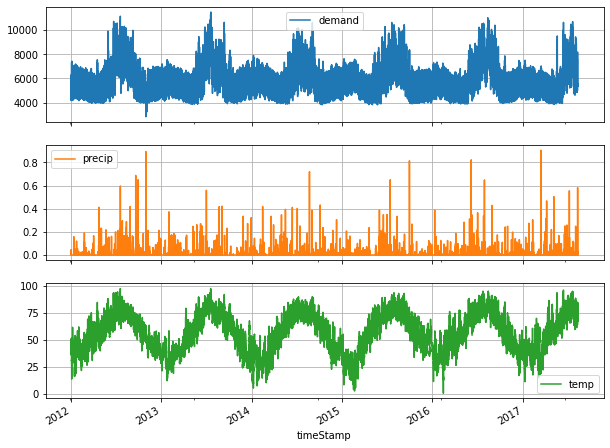

In [8]:
## plot
ny_df.plot(subplots=True, figsize=(10,8), grid = True);

In [9]:
print("Rows    : ", df.shape[0])
print("Columns : ", df.shape[1])
print("\nFeatures: \n", df.columns.tolist())
print("\nMissing Values:\n", df.isnull().any())
print("\nUnique values : \n", df.nunique())

Rows    :  49205
Columns :  4

Features: 
 ['timeStamp', 'demand', 'precip', 'temp']

Missing Values:
 timeStamp    False
demand        True
precip        True
temp          True
dtype: bool

Unique values : 
 timeStamp    49205
demand       40972
precip        1004
temp          7580
dtype: int64


                 demand    precip       temp
timeStamp                                   
2012-01-01  4954.833333  0.002487  46.510000
2012-01-02  5302.954167  0.000000  40.496667
2012-01-03  6095.512500  0.000000  26.672500
2012-01-04  6336.266667  0.000000  20.585000
2012-01-05  6130.245833  0.000000  33.577500
2012-01-06  5867.537500  0.000000  43.400833
2012-01-07  5177.441667  0.000000  51.497917
2012-01-08  5120.541667  0.000000  41.467083
2012-01-09  5890.820833  0.000000  35.360000
2012-01-10  5871.262500  0.000000  40.503333
                 demand    precip       temp
timeStamp                                   
2017-08-03  7672.781708  0.001262  75.489583
2017-08-04  7730.532292  0.003704  76.324167
2017-08-05  6657.496792  0.005629  74.172917
2017-08-06  5702.361542  0.000000  70.129167
2017-08-07  6398.154167  0.021233  68.203750
2017-08-08  6471.626042  0.000000  71.039167
2017-08-09  6811.112167  0.047529  73.852500
2017-08-10  5582.297000  0.002033  75.217500
2017-08-11

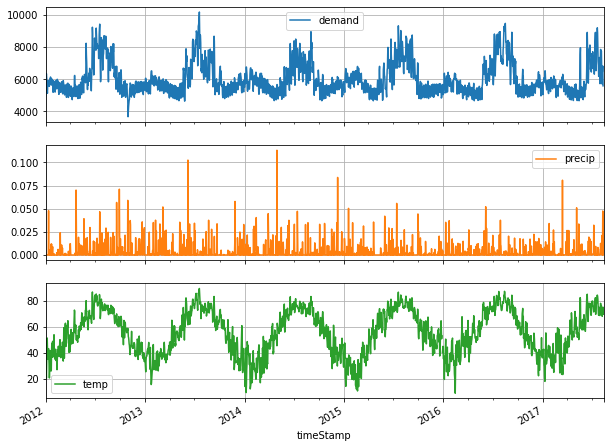

In [10]:
## Resample on month level
print(ny_df.resample('D').mean().head(10))
print(ny_df.resample('D').mean().tail(10))

## plot
ny_df.resample('D').mean().plot(subplots = True, grid=True, figsize=(10,8));

In [11]:
ny_df_daily = ny_df.resample("D").mean()

#### `Prophet Paper` : https://peerj.com/preprints/3190/

`Abstract`: "Forecasting is a common data science task that helps organizations with capacity planning, goal setting, and anomaly detection. Despite its importance, there are serious challenges associated with producing reliable and high quality forecasts — especially when there are a variety of time series and analysts with expertise in time series modeling are relatively rare. To address these challenges, we describe a practical approach to forecasting “at scale” that combines configurable models with analyst-in-the-loop performance analysis. We propose a modular regression model with interpretable parameters that can be intuitively adjusted by analysts with domain knowledge about the time series. We describe performance analyses to compare and evaluate forecasting procedures, and automatically flag forecasts for manual review and adjustment. Tools that help analysts to use their expertise most effectively enable reliable, practical forecasting of business time series."

$y(t) = g(t) + s(t) + h(t) + \epsilon_{t}$

where, <br>
$g(t)$ : trend function which models non-periodic changes in the value of thetime  series <br>
$s(t)$ : periodic  changes  (e.g.,  weekly  and  yearly  seasonality) <br>
$h(t)$ :  the effects of holidays which occur on potentially irregular schedules overone or more days <br>
$e_{t}$ : error term


In [12]:
from fbprophet import Prophet

In [13]:
ny_df_final = ny_df_daily.reset_index()[['timeStamp', 'demand', 'temp']].rename({'timeStamp':'ds', 'demand':'y', 'temp':'temp'}, axis = 'columns')
display(ny_df_final.head(10))
display(ny_df_final.tail(10))

,ds,y,temp
0,2012-01-01,4954.833333,46.510000
1,2012-01-02,5302.954167,40.496667
2,2012-01-03,6095.512500,26.672500
3,2012-01-04,6336.266667,20.585000
4,2012-01-05,6130.245833,33.577500
5,2012-01-06,5867.537500,43.400833
6,2012-01-07,5177.441667,51.497917
7,2012-01-08,5120.541667,41.467083
8,2012-01-09,5890.820833,35.360000
9,2012-01-10,5871.262500,40.503333


,ds,y,temp
2041,2017-08-03,7672.781708,75.489583
2042,2017-08-04,7730.532292,76.324167
2043,2017-08-05,6657.496792,74.172917
2044,2017-08-06,5702.361542,70.129167
2045,2017-08-07,6398.154167,68.203750
2046,2017-08-08,6471.626042,71.039167
2047,2017-08-09,6811.112167,73.852500
2048,2017-08-10,5582.297000,75.217500
2049,2017-08-11,NaN,72.767917
2050,2017-08-12,NaN,69.771429


In [14]:
## check missing values
ny_df_final.query('temp != temp')

,ds,y,temp
1457,2015-12-28,5510.776333,NaN


In [15]:
## Imputation 
ny_df_final['temp'] = ny_df_final['temp'].fillna(method = 'ffill')

In [16]:
##


In [17]:
## 
ny_df_final['month'] = ny_df_final['ds'].dt.month
ny_df_final.head()

,ds,y,temp,month
0,2012-01-01,4954.833333,46.510000,1
1,2012-01-02,5302.954167,40.496667,1
2,2012-01-03,6095.512500,26.672500,1
3,2012-01-04,6336.266667,20.585000,1
4,2012-01-05,6130.245833,33.577500,1


In [18]:
##
fig = px.line(ny_df_final, x = 'ds', y = 'y', hover_data=['temp', 'month'], title = 'NYC Energy Demand')
fig.update_xaxes(
    rangeslider_visible = True,
    rangeselector = dict(
        buttons = list([
                        dict(count = 1, label = "1y", step = "year", stepmode = "backward"),
                        dict(count = 2, label = "3y", step = "year", stepmode = "backward"),
                        dict(count = 3, label = "5y", step = "year", stepmode = "backward"),
                        dict(step = "all")
        ])
    )
)

In [19]:
##
ny_df_final[['month', 'temp']].groupby('month').agg({'temp':{'max', 'min', 'mean'}})

temp                      
             min        max       mean
month                                 
1       9.507917  55.420455  33.432140
2       9.015000  59.360000  34.517758
3      20.291667  67.878333  41.419884
4      33.045833  72.992083  52.600204
5      48.090833  82.576250  62.543994
6      52.405833  86.916667  71.334418
7      66.417083  89.606667  77.595627
8      68.042083  87.426250  75.525947
9      57.274583  84.448750  69.550306
10     42.106250  74.277500  58.642895
11     27.172500  67.606250  47.225638
12     22.429583  64.735000  41.520068

In [20]:
##
ny_df_final[['y', 'temp']].corr()

,y,temp
y,1.000000,0.560888
temp,0.560888,1.000000


In [21]:
##
ny_df_final.query('temp > 80')[['y','temp']].corr()

,y,temp
y,1.000000,0.552918
temp,0.552918,1.000000


In [22]:
##
ny_df_final.query('temp <= 80')[['y', 'temp']].corr()

,y,temp
y,1.000000,0.470562
temp,0.470562,1.000000


In [23]:
##
def summer_temp(temp):
    if temp > 80:
        return 1
    else:
        return 0

In [24]:
## Additional Features 
ny_df_final['summer_temp'] = ny_df_final['temp'].apply(summer_temp)

## 
ny_df_final['month_bins'] = pd.cut(ny_df_final['month'], bins = 3, labels = False)

display(ny_df_final.head())
display(ny_df_final.tail())

,ds,y,temp,month,summer_temp,month_bins
0,2012-01-01,4954.833333,46.510000,1,0,0
1,2012-01-02,5302.954167,40.496667,1,0,0
2,2012-01-03,6095.512500,26.672500,1,0,0
3,2012-01-04,6336.266667,20.585000,1,0,0
4,2012-01-05,6130.245833,33.577500,1,0,0


,ds,y,temp,month,summer_temp,month_bins
2046,2017-08-08,6471.626042,71.039167,8,0,1
2047,2017-08-09,6811.112167,73.852500,8,0,1
2048,2017-08-10,5582.297000,75.217500,8,0,1
2049,2017-08-11,NaN,72.767917,8,0,1
2050,2017-08-12,NaN,69.771429,8,0,1


In [25]:
## training and testing dataset
train = ny_df_final[(ny_df_final['ds'] >= '2012-01-01') & (ny_df_final['ds'] <= '2017-04-30')]
test = ny_df_final[(ny_df_final['ds'] > '2017-04-30')]

print("Train dataset shape: ", train.shape)
print("Test dataset shape: ", test.shape)

Train dataset shape:  (1947, 6)
Test dataset shape:  (104, 6)


In [26]:
m = Prophet(interval_width = 0.95, yearly_seasonality = True)
m.add_regressor('summer_temp', standardize = False)
m.add_regressor('month_bins', standardize = False, mode = 'multiplicative')

In [27]:
##
m.fit(train)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [28]:
##
m.params

OrderedDict([('k', array([[0.14760422]])),
             ('m', array([[0.58876607]])),
             ('delta',
              array([[-4.71416526e-08, -6.41586311e-06, -1.82744926e-01,
                      -1.67782383e-07, -1.74103167e-08,  1.22142120e-02,
                       7.69355196e-03,  2.98750794e-03,  9.89830150e-08,
                       3.31189176e-08, -3.32094703e-08, -3.81719061e-02,
                      -2.42237664e-05,  7.15586204e-08,  1.40721628e-01,
                       3.60042834e-07, -3.04861026e-07, -9.94059548e-02,
                      -4.33196683e-02,  3.01139014e-08,  6.19431008e-08,
                       5.68495201e-08,  3.76665581e-02,  2.84149406e-02,
                       1.32793754e-07]])),
             ('sigma_obs', array([[0.03884209]])),
             ('beta',
              array([[-0.03548167, -0.05910135,  0.04945314,  0.04015359, -0.00950002,
                      -0.00176236, -0.007792  , -0.00252906,  0.00343317, -0.00585251,
                 

In [29]:
##
future = m.make_future_dataframe(periods = 104)
future.tail()

,ds
2046,2017-08-08
2047,2017-08-09
2048,2017-08-10
2049,2017-08-11
2050,2017-08-12


In [30]:
##
future['summer_temp'] = ny_df_final['summer_temp']
future['month_bins'] = ny_df_final['month_bins']
future

,ds,summer_temp,month_bins
0,2012-01-01,0,0
1,2012-01-02,0,0
2,2012-01-03,0,0
3,2012-01-04,0,0
4,2012-01-05,0,0
...,...,...,...
2046,2017-08-08,0,1
2047,2017-08-09,0,1
2048,2017-08-10,0,1
2049,2017-08-11,0,1


In [31]:
##
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
2046,2017-08-08,7383.695055,6582.959648,8157.814624
2047,2017-08-09,7394.540415,6608.434968,8185.993882
2048,2017-08-10,7364.877855,6614.261472,8102.577885
2049,2017-08-11,7314.672167,6570.852914,8094.070726
2050,2017-08-12,6733.792052,6003.490868,7544.431949


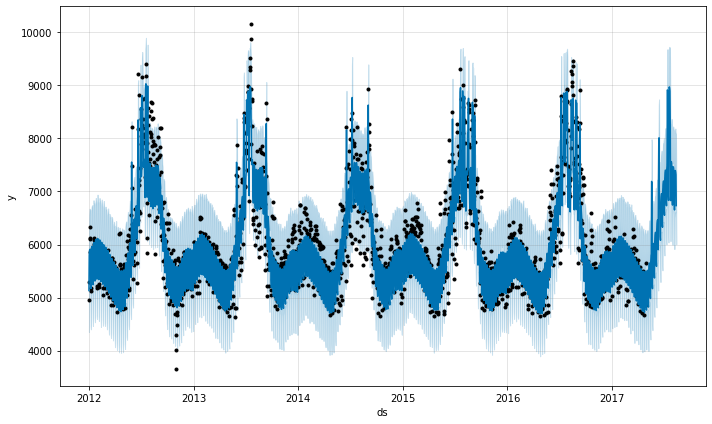

In [32]:
fig1 = m.plot(forecast)

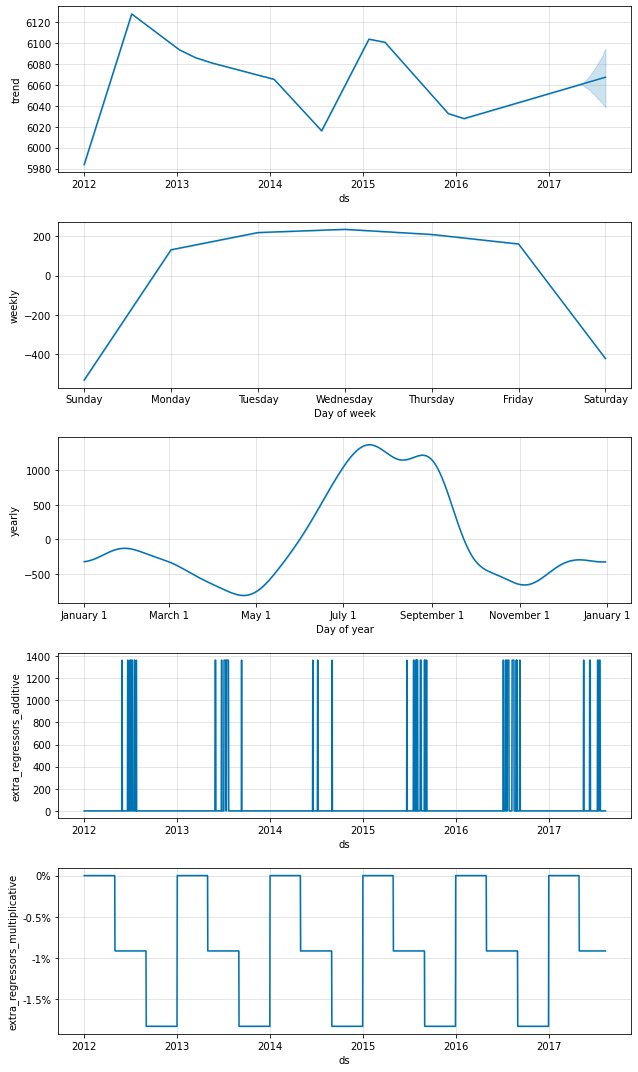

In [33]:
fig2 = m.plot_components(forecast)

In [34]:
##
from fbprophet.diagnostics import cross_validation, performance_metrics
cv_results = cross_validation(model = m, initial = '731 days', horizon = '365 days')
df_p = performance_metrics(cv_results)
df_p.head(10)

INFO:fbprophet:Making 5 forecasts with cutoffs between 2014-05-01 00:00:00 and 2016-04-30 00:00:00


,horizon,mse,rmse,mae,mape,mdape,coverage
0,36 days 12:00:00,204293.922864,451.988853,352.610429,0.062543,0.051056,0.890110
1,37 days 00:00:00,210424.439085,458.720437,359.614485,0.063723,0.051274,0.890110
2,37 days 12:00:00,211653.376540,460.058014,361.875027,0.064102,0.051798,0.890110
3,38 days 00:00:00,215758.752010,464.498388,365.841034,0.064497,0.053251,0.884615
4,38 days 12:00:00,217944.760867,466.845543,369.633793,0.065097,0.054411,0.884615
5,39 days 00:00:00,216769.115929,465.584703,368.348028,0.064761,0.054411,0.884615
6,39 days 12:00:00,218512.981645,467.453721,371.887454,0.065343,0.054780,0.884615
7,40 days 00:00:00,219872.975963,468.906148,373.568580,0.065602,0.054780,0.884615
8,40 days 12:00:00,220796.677013,469.890069,375.724080,0.065973,0.055551,0.884615
9,41 days 00:00:00,228115.454594,477.614337,383.996480,0.067134,0.058302,0.879121


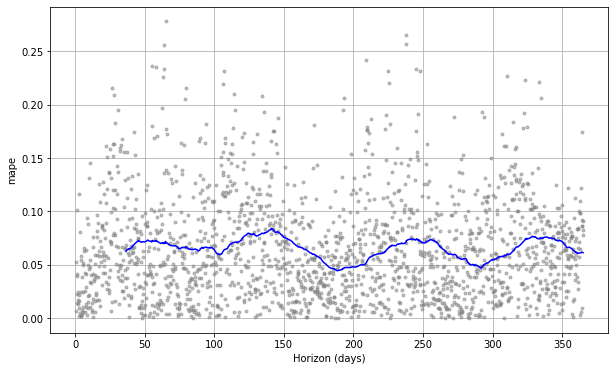

In [35]:
## plot model performance
from fbprophet.plot import plot_cross_validation_metric
fig3 = plot_cross_validation_metric(cv_results, metric = 'mape')